# Semana 5: CNN + Transfer Learning
#### Equipo 5:
Jackeline Conant Rubalcava A01280544 \
Javier Eduardo Corrales Cardoza A01742328 \
José Andrés Orantes Guillén A01174130 \
Francisco Salas Porras A01177893 \
Luis Mario Lozoya Chairez A00833364

## Introducción al Notebook

Hello

* Importación de librerías 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import tensorflow_datasets as tfds

https://www.tensorflow.org/datasets/catalog/rock_paper_scissors


In [2]:
dataset_name = "rock_paper_scissors"

In [3]:
(train_data, test_data), dataset_info = tfds.load(
    name = dataset_name,
    split=['train','test'],
    as_supervised = True,
    with_info= True
)

In [4]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='C:\\Users\\jacke\\tensorflow_datasets\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-data

In [5]:
x_train, y_train = [], []
x_test, y_test = [], []

# Extract training data
for image, label in tfds.as_numpy(train_data):  # Convert to NumPy for easier manipulation
    x_train.append(image)
    y_train.append(label)

# Extract test data
for image, label in tfds.as_numpy(test_data):
    x_test.append(image)
    y_test.append(label)

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Expande la dimensión de y_train y y_test
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [6]:
print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (2520, 300, 300, 3) (2520, 1)
Testing data shape :  (372, 300, 300, 3) (372, 1)


In [7]:
print(y_train)

[[2]
 [2]
 [0]
 ...
 [1]
 [1]
 [1]]


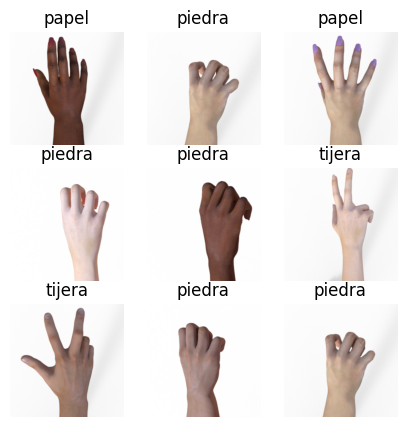

In [8]:
# Definir las etiquetas de las clases
class_names = ['piedra','papel','tijera']

# Seleccionar 9 imágenes aleatorias
indices = np.random.choice(len(x_train), 9, replace=False)
images = x_train[indices]
labels = y_train[indices]

# Crear una cuadrícula de 3x3 para mostrar las imágenes
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i][0]])
    plt.axis('off')
plt.show()